23 iterations were performed
Distances of clusters as compared to last generation:[0.04026480312317236, 0.04319969695803219, 0.0, 0.0, 0.0]
Runtime: 0:00:05.170099
kmeans centroids: [[-20.71831322  47.80910492]
 [-45.63034058 -30.76457024]
 [ 49.1815567  -69.63302612]
 [ 89.78514862 177.08178711]
 [173.70593262 -25.57697487]]
Runtime: 0:00:00.183088


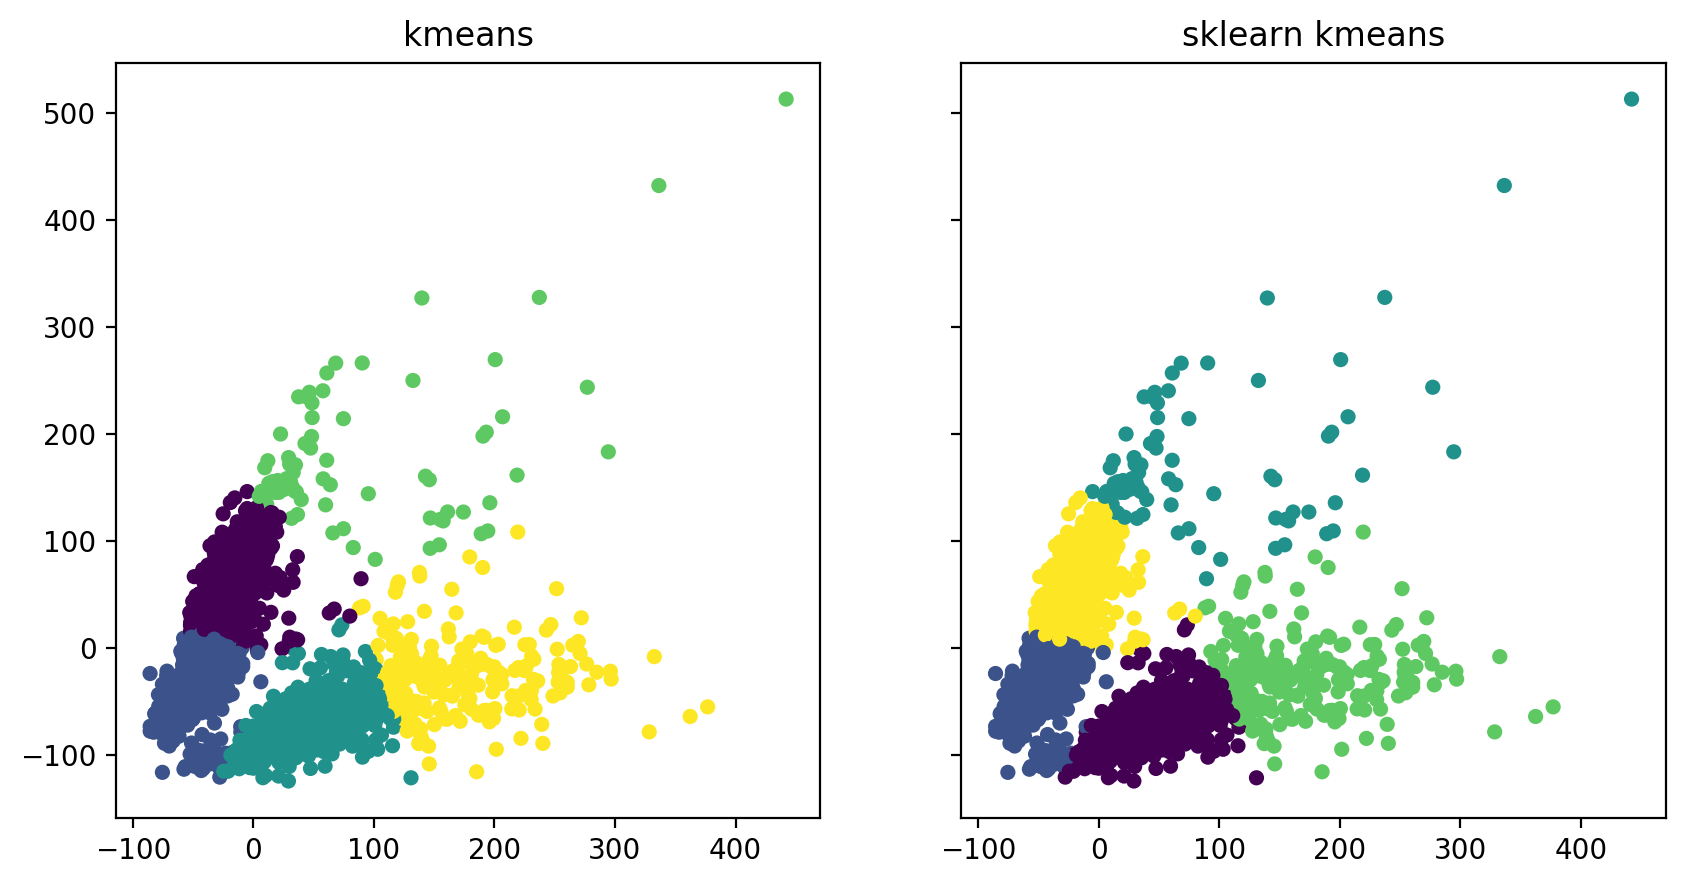

sklearnkmeans centroids: [[ 46.525562 -70.98865 ]
 [-45.991882 -31.193031]
 [ 85.9695   173.40833 ]
 [170.06161  -26.324238]
 [-21.144766  46.789627]]


In [21]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t = 0
patients = 0
genes = 0
centroids_array = 0 
centroids_oldarray = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data))* np.random.random_sample((k, genes)) + np.amin(pca_data)

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
        
#Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    print("Distances of clusters as compared to last generation:" + str(distances))
        
    
                  
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        empty_check()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1
        improv()

#kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # set threshold
    improv()

# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
#runtime_start()
#kmeans(5, 10)
#print(runtime_end())

#Execute threshold kmeans
runtime_start()
tkmeans(5)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


#%%



